

# Initial Setup



In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from PIL import Image

# Set the seed for random operations. 
# Letting experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED) 
np.random.seed(SEED)

# Get current working directory
cwd = os.getcwd()

In [3]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Dec 15 04:11:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Preprocessing function

In [6]:
MASK_LIMITS_HSV = ((30,40,70), (80,255,255))

In [7]:
import cv2 as cv

def mask_image(image: np.array):
  
    image_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)

    designed_mask = cv.inRange(image_hsv, *MASK_LIMITS_HSV)

    denoised_mask = cv.morphologyEx(designed_mask, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_RECT, (7,7)))

    dilatated_mask = cv.dilate(denoised_mask, np.ones((5,5),np.uint8), iterations = 3)

    image_masked = cv.bitwise_and(image, image, mask = dilatated_mask)

    return image_masked

# Dataset Retrieval

In [167]:
# Option to set to true the first time to RETRIEVE the dataset and create the
# folder structure. If set to false it expects the dataset to be already 
# splitted and zipped in your drive in the directory "Challenge_2".
SPLIT_DATASET = True

# This option let you use your dataset_split.json file, that must be located in 
# your drive in the directory "Challenge_2", for the dataset split.
# Is considered only if SPLIT_DATASET == True since if SPLIT_DATASET == 
# False the dataset is expected to be already splitted and zipped in your
# drive in the directory "Challenge_2".
LOAD_FROM_JSON = True

### Cells executed if: SPLIT_DATASET = True 

In [168]:
if SPLIT_DATASET == True:
  ! unzip '/content/drive/My Drive/Challenge_2/Development_Dataset.zip'

Archive:  /content/drive/My Drive/Challenge_2/Development_Dataset.zip
  inflating: Development_Dataset/LICENSE.txt  
   creating: Development_Dataset/Test_Dev/
   creating: Development_Dataset/Test_Dev/Bipbip/
   creating: Development_Dataset/Test_Dev/Bipbip/Haricot/
   creating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00211.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00581.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00721.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00951.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_01341.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02421.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02781.jpg  
  inflati

In [169]:
# -----------------------------
# Create the dataset_split.json 
# -----------------------------
if SPLIT_DATASET == True and LOAD_FROM_JSON == False:

  from PIL import Image
  import json
  
  VALIDATION_SPLIT = 0.15

  split = {}
  split['training'] = {}
  split['validation'] = {}

  teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
  plants = ['Haricot', 'Mais']

  # Random seed for reproducibility
  np.random.seed(SEED)

  for t in teams:

    split['training'][t] = {}
    split['validation'][t] = {}

    for p in plants:

      split['training'][t][p] = []      
      split['validation'][t][p] = []

      image_filenames = os.listdir('/content/Development_Dataset/Training/' + t + '/' + p + '/' + 'Images')
      # Order images files to get always the same split
      image_filenames = sorted(image_filenames)
          
      # Create training split
      for i in range(int(len(image_filenames) * (1 - VALIDATION_SPLIT))):
        image_name = image_filenames[i].split('.')
        split['training'][t][p].append(image_name)

      
      # Create validation split
      for j in range(i + 1, len(image_filenames)):
        image_name = image_filenames[j].split('.')
        split['validation'][t][p].append(image_name)

  with open(os.path.join(cwd, 'dataset_split.json'), 'w') as f:
    json.dump(split, f)

  ! cp '/content/dataset_split.json' '/content/drive/My Drive/Challenge_2/dataset_split.json'

In [ ]:
# ------------------------------------------
# Create the splitted dataset directory tree 
# ------------------------------------------
if SPLIT_DATASET == True:
  import shutil
  
  # Use your dataset_split.json 
  # ---------------------------
  if LOAD_FROM_JSON == True:
    import json
    f = open('/content/drive/My Drive/Challenge_2/dataset_split.json')
    split = json.load(f) 
    ! cp '/content/drive/My Drive/Challenge_2/dataset_split.json' '/content/dataset_split.json'  
  # ---------------------------


  # Create the folder for the splitted dataset
  # ------------------------------------------
  ! mkdir '/content/Development_Dataset_processed'

  ! mkdir '/content/Development_Dataset_processed/training'
  ! mkdir '/content/Development_Dataset_processed/training/images'
  ! mkdir '/content/Development_Dataset_processed/training/masks'

  ! mkdir '/content/Development_Dataset_processed/validation'
  ! mkdir '/content/Development_Dataset_processed/validation/images'
  ! mkdir '/content/Development_Dataset_processed/validation/masks'
  # ------------------------------------------

  teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
  plants = ['Haricot', 'Mais']

  which_dataset = ['training', 'validation']

  for d in which_dataset:
    
    for t in teams:
      for p in plants:
        
        for img_name in split[d][t][p]:
          
          # Image preprocessing and saving
          # ------------------------------
          src_path = os.path.join(cwd, 'Development_Dataset/Training', t, p, 'Images', img_name[0] + '.' + img_name[1])
          dst_path = os.path.join(cwd, 'Development_Dataset_processed', d, 'images', img_name[0] + '.' + img_name[1])
          
          # Processing the image
          # --------------------
          current_image = cv.imread(src_path, cv.IMREAD_COLOR)     
          current_image = cv.cvtColor(current_image, cv.COLOR_BGR2RGB)
          preprocessed_image = mask_image(current_image)
          # --------------------
          
          cv.imwrite(dst_path, preprocessed_image)
          # ------------------------------

          #shutil.copy(src_path, dst_path)


          # Mask preprocessing and saving
          # -----------------------------
          src_path = os.path.join(cwd, 'Development_Dataset/Training', t, p, 'Masks', img_name[0] + '.png')
          dst_path = os.path.join(cwd, 'Development_Dataset_processed', d, 'masks', img_name[0] + '.npy')

          # Read Image
          mask = Image.open(src_path)
          # Image to np array
          mask_arr = np.array(mask)
    
          # RGB to target
          # -------------
          new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

          # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
          new_mask_arr[np.where(np.all(mask_arr == [0, 0, 0], axis=-1))] = 0
          new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))] = 0
          new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
          new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

          mask_arr = np.expand_dims(new_mask_arr, -1)
          # -------------

          np.save(dst_path, mask_arr)
          # -----------------------------
  ! ls

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

In [ ]:
# ------------------------------------------------------------------------------------------
# Zip the splitted dataset for the next executions, to avoid the splitting process each time
# ------------------------------------------------------------------------------------------
if SPLIT_DATASET == True:
  ! zip -r '/content/drive/My Drive/Challenge_2/Development_Dataset_processed.zip' 'Development_Dataset_processed'

### Cells executed if: SPLIT_DATASET = False 

In [ ]:
# --------------------------------------------------------------------------------
# Unzip the json file with the split used and the splitted dataset from your drive
# --------------------------------------------------------------------------------
if SPLIT_DATASET == False:
  # Get dataset_split.json
  ! cp '/content/drive/My Drive/Challenge_2/dataset_split.json' '/content/dataset_split.json' 
  # Get the splitted dataset
  ! unzip '/content/drive/My Drive/Challenge_2/Development_Dataset_processed.zip'

In [ ]:
import json

subset_file = os.path.join('/content', 'dataset_split.json')
with open(subset_file, 'r') as f:
  data = json.load(f)

data


# Dataset Setup

In [72]:
# --------------------------------------------------------------------------------------
# Create the training and validation ImageDataGenerator objects for from scratch network
# --------------------------------------------------------------------------------------
def data_generator(apply_data_augmentation):

  from tensorflow.keras.preprocessing.image import ImageDataGenerator

  apply_data_augmentation = True

  # Create training ImageDataGenerator object
  # We need two different generators for images and corresponding masks
  if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')

    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')
    
  return img_data_gen, mask_data_gen

In [73]:
# --------------------------------
# Create the class for the dataset
# --------------------------------

from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[500, 500]):
    import json
    
    subset_file = os.path.join('/content', 'dataset_split.json')
    with open(subset_file, 'r') as f:
      split = json.load(f)
    
    teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
    plants = ['Haricot', 'Mais']
    
    subset_filenames = []
    
    for t in teams:
      for p in plants:
        
        for img_name in split[which_subset][t][p]:
          subset_filenames.append(img_name)
    
    np.random.seed(1234)
    np.random.shuffle(subset_filenames)

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape
    self.SEED = 1234

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, self.which_subset, 'images', curr_filename[0] + '.' + curr_filename[1]))
    mask_arr = np.load(os.path.join(self.dataset_dir, self.which_subset, 'masks', curr_filename[0] + '.npy'))   

    # Resize image and mask
    img = img.resize(self.out_shape) #size – The requested size in pixels, as a 2-tuple: (width, height). !!!!!!!!!!! ATTENTION !!!!!!!!!
    mask_arr = tf.image.resize(mask_arr, size = [self.out_shape[1], self.out_shape[0]], method = 'nearest').numpy()  # !!!!! (height, width) since i tensorflow

    img_arr = np.array(img)
    #mask_arr = np.array(mask)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        #self.SEED = self.SEED + 1
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=self.SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=self.SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [74]:
# ------------------------------------------------------------------
# Create train and validation dataset objects using the custom class
# ------------------------------------------------------------------
def create_dataset(img_data_gen, mask_data_gen, img_h, img_w, bs, num_classes):

  # Training
  # --------
  dataset = CustomDataset('/content/Development_Dataset_processed',
                          'training', 
                          img_generator=img_data_gen, 
                          mask_generator=mask_data_gen,
                          out_shape=[img_w, img_h] # size – The requested size in pixels, as a 2-tuple: (width, height).
                          )
  
  train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                                 output_types=(tf.float32, tf.float32),
                                                 output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
  train_dataset = train_dataset.batch(bs)

  train_dataset = train_dataset.repeat()
  # --------

  # Validation
  # ----------
  dataset_valid = CustomDataset('/content/Development_Dataset_processed',
                               'validation',
                               out_shape=[img_w, img_h] # size – The requested size in pixels, as a 2-tuple: (width, height).
                               )
   
  valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                                 output_types=(tf.float32, tf.float32),
                                                 output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
  valid_dataset = valid_dataset.batch(bs)

  valid_dataset = valid_dataset.repeat()
  # ----------

  return train_dataset, dataset, valid_dataset, dataset_valid

# Data generator test

In [157]:
# Let's test data generator
# -------------------------

apply_data_augmentation = True

tmp_img_h = 368
tmp_img_w = 512

[img_data_gen, mask_data_gen] = data_generator(apply_data_augmentation)

[train_dataset, dataset, valid_dataset, dataset_valid] = create_dataset(img_data_gen, mask_data_gen, img_h = tmp_img_h, img_w = tmp_img_w, bs = 8, num_classes = 3)

import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(train_dataset)

In [158]:
augmented_img, target = next(iterator)
augmented_img.shape
target.shape

TensorShape([8, 368, 512, 3])

TensorShape([8, 368, 512, 1])

[0. 1. 2.]


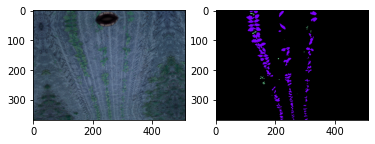

In [159]:
fig, ax = plt.subplots(1, 2)

augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

# Model setup

## Model

In [91]:
def Efficient_Unet(input_shape = (896, 1280, 3)):
  efficient = tf.keras.applications.EfficientNetB7(weights='imagenet', include_top=False, input_shape = input_shape)
  
  # We only use: 
  # efficient.layers[:-3]
  
  input = efficient.input

  out_eff = efficient.get_layer('block7d_add').output

  # Up.Conv
  # -------
  skip_unpoolb7 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(out_eff)
  
  convb7 = tf.keras.layers.Conv2D(filters = 512, kernel_size=(3, 3), padding = 'same')(skip_unpoolb7)
  # -------

  # Concat b6
  # -------
  skip_unpoolb6 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(efficient.get_layer('block6m_add').output)

  concatb6 = tf.keras.layers.Concatenate()([skip_unpoolb6, convb7])
  # -------

  # Conv + Upsampling
  # -------
  conv2 = tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same')(concatb6)
  
  unpool2 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(conv2)
  # -------


  # Concat b4
  # ---------
  skip_unpoolb4 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(efficient.get_layer('block4g_add').output)

  concatb4 = tf.keras.layers.Concatenate()([skip_unpoolb4, unpool2])
  # ---------

  # Conv + Upsampling
  # -----------------
  conv3 = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same')(concatb4)
  
  unpool3 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(conv3)
  # ----------------- 
  
  # Concat b3
  # ---------
  skip_unpoolb3 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(efficient.get_layer('block3g_add').output)

  concatb3 = tf.keras.layers.Concatenate()([skip_unpoolb3, unpool3])
  # ---------
  
  # Conv + Upsampling
  # -----------------
  conv4 = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same')(concatb3)
  
  unpool4 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(conv4)
  # ----------------- 

  # Concat b2
  # ---------
  skip_unpoolb2 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(efficient.get_layer('block2g_add').output)

  concatb2 = tf.keras.layers.Concatenate()([skip_unpoolb2, unpool4])
  # ---------

  # Conv + Upsampling
  # -----------------
  conv5 = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same')(concatb2)
  
  unpool5 = tf.keras.layers.UpSampling2D(size=(2 ,2), interpolation = 'bilinear')(conv5)
  # ----------------- 

  output = tf.keras.layers.Conv2D(filters = 3, kernel_size= (1, 1), strides = (1, 1), activation = 'softmax')(unpool5)

  model = tf.keras.Model(inputs = input, outputs = output)
  
  model.summary()

  return model

## Setup functions

In [119]:
def define_transfer_learning(input_size = (768, 1024, 3)):

  eff_unet_model = Efficient_Unet(input_shape = input_size)
  
  eff_unet_model.trainable = True

  train = False
  for layer in eff_unet_model.layers:
    if train:
      layer.trainable = True
    else:
      layer.trainable = False
    if layer.name == 'block7d_add':
      train = True

  model = tf.keras.Sequential()
  
  model.add(eff_unet_model)

  #eff_unet_model.summary()
  model.summary()

  return model

In [120]:
def define_fine_tuning(input_size = (896, 1280, 3),):

  eff_unet_model = Efficient_Unet(input_shape = input_size)

  for layer in eff_unet_model.layers:
    layer.trainable = True

  model = tf.keras.Sequential()
  
  model.add(eff_unet_model)

  model.summary()

  return model

In [121]:
# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):

  # get predicted class from softmax
  y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

  per_class_iou = []

  for i in range(1,3): # exclude the background class 0

    # Get prediction and target related to only a single class (i)
    class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
    class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
    intersection = tf.reduce_sum(class_true * class_pred)
    union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
    iou = (intersection + 1e-7) / (union + 1e-7)
    per_class_iou.append(iou)

  return tf.reduce_mean(per_class_iou)

In [130]:
# -----------------
# Compile the model
# -----------------
def compile_model(model, lr):

  # Optimization params
  # -------------------

  # Loss
  # ----
  # Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
  loss = tf.keras.losses.SparseCategoricalCrossentropy()
  # ----

  # Optimization function
  # ---------------------
  optimizer = tfa.optimizers.RectifiedAdam(learning_rate=lr) #tf.keras.optimizers.Adam(learning_rate=lr)
  # ---------------------

  # Validation metrics
  # ------------------
  mIoU = meanIoU
  metrics = ['accuracy', mIoU]
  # ------------------

  # Compile Model
  # -------------
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights = [1.5133127348818056, 14.139274748955497, 20.349217406952828])
  # -------------

  # -------------------
  
  return model

In [128]:
# -----------------
# Set the callbacks
# -----------------
def set_callbacks(type, model_checkpoint, visualize_tensorboard, early_stop, reduce_lr_on_plateau):
  
  import os
  from datetime import datetime

  cwd = os.getcwd()

  exps_dir = os.path.join('/content/drive/My Drive/Challenge_2/', 'segmentation_experiments')
  if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

  model_name = type

  exp_dir = os.path.join(exps_dir, model_name)
  if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
  callbacks = []

  # Model checkpoint
  # ----------------
  if model_checkpoint:
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                       save_weights_only=True,
                                                       save_best_only=True)  # False to save the model directly
    callbacks.append(ckpt_callback)
  # ----------------

  # Visualize Learning on Tensorboard
  # ---------------------------------
  if visualize_tensorboard:
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
    
    # By default shows losses and metrics for both training and validation
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                                 profile_batch=0,
                                                 histogram_freq=1)  # if 1 shows weights histograms
    callbacks.append(tb_callback)
  # ---------------------------------

  # Early Stopping
  # --------------
  if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                   patience = 15,
                                                   restore_best_weights=True)
    callbacks.append(es_callback)
  # --------------

  # Reduce Learning rate on plateau
  # -------------------------------
  if reduce_lr_on_plateau:
    rlr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                        factor=0.5, 
                                                        patience=4, 
                                                        verbose=1, 
                                                        mode='auto', 
                                                        min_delta=0.0001)
    callbacks.append(rlr_callback)
  # -------------------------------

  return callbacks

In [125]:
# -----------
# Train model
# -----------
def train_model(model, train_dataset, dataset, valid_dataset, dataset_valid, callbacks, num_epochs, bs):
  
  history_model = model.fit(x = train_dataset,
                            epochs = num_epochs,  #### set repeat in training dataset
                            steps_per_epoch = int(np.ceil(len(dataset) / bs)),
                            validation_data = valid_dataset,
                            validation_steps = int(np.ceil(len(dataset_valid) / bs)), 
                            callbacks = callbacks)
  
  return history_model

# Training

In [98]:
# --------------------------------------
# Train the model with transfer learning
# --------------------------------------
def train_transfer_learning():
  
  apply_data_augmentation = True

  img_h = int(896/2)
  img_w = int(1280/2)

  num_classes = 3

  bs = 10

  lr = 1e-5

  num_epochs = 200

  model_checkpoint = True
  visualize_tensorboard = False
  early_stop = False
  reduce_lr_on_plateau = True

  print('--------------------------------------------')
  print('Image heigth                      ---> ' + str(img_h))
  print('Image width                       ---> ' + str(img_w))
  print('Batch size                        ---> ' + str(bs))
  print('Learning rate                     ---> ' + str(lr))
  print('Number of epochs                  ---> ' + str(num_epochs))
  print('Model checkpoint                  ---> ' + str(model_checkpoint))
  print('Visualize tensorboars             ---> ' + str(visualize_tensorboard))
  print('Early stopping                    ---> ' + str(early_stop))
  print('Reduce learning rate on plateau   ---> ' + str(reduce_lr_on_plateau))
  print('--------------------------------------------')

  [img_data_gen, mask_data_gen] = data_generator(apply_data_augmentation)

  [train_dataset, dataset, valid_dataset, dataset_valid] = create_dataset(img_data_gen, mask_data_gen, img_h = img_h, img_w = img_w, bs = bs, num_classes = num_classes)

  model = define_transfer_learning(input_size = (img_h, img_w, 3))
  
  model = compile_model(model, lr = lr)

  callbacks = set_callbacks('eff-Unet_transfer_learning_with_pre_img_and_mean_freq_class_weights', model_checkpoint = model_checkpoint, visualize_tensorboard = visualize_tensorboard, early_stop = early_stop, reduce_lr_on_plateau = reduce_lr_on_plateau)

  history = train_model(model, train_dataset, dataset, valid_dataset, dataset_valid, callbacks, num_epochs = num_epochs, bs = bs)

  plot_history(history)

  return model, history

In [99]:
# --------------------------------------
# Train the model with transfer learning
# --------------------------------------
def train_fine_tuning():
  
  apply_data_augmentation = True

  img_h = int(896/2)
  img_w = int(1280/2)

  num_classes = 3

  bs = 2

  lr = 1e-6

  num_epochs = 100

  model_checkpoint = True
  visualize_tensorboard = False
  early_stop = True
  reduce_lr_on_plateau = True

  print('--------------------------------------------')
  print('Image heigth                      ---> ' + str(img_h))
  print('Image width                       ---> ' + str(img_w))
  print('Batch size                        ---> ' + str(bs))
  print('Learning rate                     ---> ' + str(lr))
  print('Number of epochs                  ---> ' + str(num_epochs))
  print('Model checkpoint                  ---> ' + str(model_checkpoint))
  print('Visualize tensorboars             ---> ' + str(visualize_tensorboard))
  print('Early stopping                    ---> ' + str(early_stop))
  print('Reduce learning rate on plateau   ---> ' + str(reduce_lr_on_plateau))
  print('--------------------------------------------')

  [img_data_gen, mask_data_gen] = data_generator(apply_data_augmentation)

  [train_dataset, dataset, valid_dataset, dataset_valid] = create_dataset(img_data_gen, mask_data_gen, img_h = img_h, img_w = img_w, bs = bs, num_classes = num_classes)

  model = define_fine_tuning(input_size = (img_h, img_w, 3))
  
  exps_dir = os.path.join('/content/drive/My Drive/Challenge_2/', 'segmentation_experiments')
  model_name = 'efficient-Unet_transfer_learning'
  exp_dir = os.path.join(exps_dir, model_name)
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  latest = tf.train.latest_checkpoint(ckpt_dir)
  print(latest)
  model.load_weights(latest)
  
  model = compile_model(model, lr = lr)

  callbacks = set_callbacks('efficient-Unet_fine_tuning', model_checkpoint = model_checkpoint, visualize_tensorboard = visualize_tensorboard, early_stop = early_stop, reduce_lr_on_plateau = reduce_lr_on_plateau)

  history = train_model(model, train_dataset, dataset, valid_dataset, dataset_valid, callbacks, num_epochs = num_epochs, bs = bs)

  plot_history(history)

  return model, history

# Plots

In [100]:
# ------------------------------------------------------------------------------
# Plot the history of the trained model (loss, val_loss; accuracy, val_accuracy)
# ------------------------------------------------------------------------------
def plot_history(history):
  from matplotlib import pyplot

  pyplot.figure()
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='validation')
  pyplot.legend()
  pyplot.show()

  pyplot.figure()
  pyplot.plot(history.history['accuracy'], label='train')
  pyplot.plot(history.history['val_accuracy'], label='validation')
  pyplot.legend()
  pyplot.show()

  pyplot.figure()
  pyplot.plot(history.history['meanIoU'], label='train')
  pyplot.plot(history.history['val_meanIoU'], label='validation')
  pyplot.legend()
  pyplot.show() 

# Execution

## Transfer Learning

In [131]:
[model, history] = train_transfer_learning() # Efficient-Unet transfer learning i.e. train only decoder

--------------------------------------------
Image heigth                      ---> 448
Image width                       ---> 640
Batch size                        ---> 10
Learning rate                     ---> 1e-05
Number of epochs                  ---> 200
Model checkpoint                  ---> True
Visualize tensorboars             ---> False
Early stopping                    ---> False
Reduce learning rate on plateau   ---> True
--------------------------------------------
Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 448, 640, 3) 0                                            
__________________________________________________________________________________________________
rescaling_10 (Rescaling)        (None, 448, 640, 3)  0           input_11[0][0]                  

KeyboardInterrupt: ignored

## Fine Tuning

In [ ]:
[model, history] = train_fine_tuning() # transfer learning of EFF-Unet

# See predictions from the network

In [133]:
apply_data_augmentation = True

img_h = int(896/2)
img_w = int(1280/2)

num_classes = 3

bs = 6

[img_data_gen, mask_data_gen] = data_generator(apply_data_augmentation)

[train_dataset, dataset, valid_dataset, dataset_valid] = create_dataset(img_data_gen, mask_data_gen, img_h = img_h, img_w = img_w, bs = bs, num_classes = num_classes)

model = define_transfer_learning(input_size = (img_h, img_w, 3)) #define_bonnet(input_size = (img_h, img_w, 3))

exps_dir = os.path.join('/content/drive/My Drive/Challenge_2/', 'segmentation_experiments')
model_name = 'eff-Unet_transfer_learning_with_pre_img_and_mean_freq_class_weights'#'bonnet_rect'
exp_dir = os.path.join(exps_dir, model_name)
ckpt_dir = os.path.join(exp_dir, 'ckpts')
latest = tf.train.latest_checkpoint(ckpt_dir)
print(latest)
model.load_weights(latest)

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 448, 640, 3) 0                                            
__________________________________________________________________________________________________
rescaling_11 (Rescaling)        (None, 448, 640, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
normalization_11 (Normalization (None, 448, 640, 3)  7           rescaling_11[0][0]               
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 449, 641, 3)  0           normalization_11[0][0]           
______________________________________________________________________________________

In [134]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

iterator = iter(valid_dataset)

In [135]:
image, target = next(iterator)

(1, 448, 640, 3)

(1, 448, 640)


<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(448, 640), dtype=int64, numpy=
array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>>

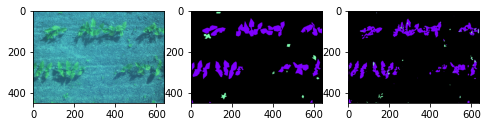

In [136]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()

image = image[0]
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape
print(tf.argmax(out_sigmoid, -1).shape)

predicted_class = predicted_class[0, ...]

predicted_class.numpy

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 3):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)

# Create prediction.json

In [138]:
! unzip '/content/drive/My Drive/Challenge_2/Development_Dataset.zip'

Archive:  /content/drive/My Drive/Challenge_2/Development_Dataset.zip
replace Development_Dataset/LICENSE.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Development_Dataset/LICENSE.txt  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00211.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00581.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00721.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00951.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_01341.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02421.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02781.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02841.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/H

In [139]:
def rle_encode(img):
  '''
  img: numpy array, 1 - foreground, 0 - background
  Returns run length as string formatted
  '''
  pixels = img.flatten()
  pixels = np.concatenate([[0], pixels, [0]])
  runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
  runs[1::2] -= runs[::2]
  
  return ' '.join(str(x) for x in runs)

In [150]:
import os
import json
import numpy as np
from PIL import Image

    # The submission file will be a zip file containing the a
    # submission.json file.

    # It must have the following structure:

    # - image name (without any extension, e.g., png, jpg, etc.)
    #   - shape: shape of the original image as list [Height, Width]
    #   - team: team of the original image. One in {'Bipbip', 'Pead', 'Roseau', 'Weedelec'}
    #   - crop: crop of the original image. One in {'Haricot', 'Mais'}
    #   - segmentation: prediction (as a dict)
    #     - crop: RLE encoded crop segmentation (no weed)
    #     - weed: RLE encoded weed segmentation (no crop)

    # Please refer to the folder structure of the given dataset to fill
    # the team and crop keys.

teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
plants = ['Haricot', 'Mais']

submission_dict = {}

for t in teams:
  for p in plants:

    tmp_path = '/content/Development_Dataset/Test_Dev/' + t + '/' + p + '/' + 'Images'
    
    image_filenames = os.listdir(tmp_path)

    for img_name in image_filenames:
      
      tmp_path = '/content/Development_Dataset/Test_Dev/' + t + '/' + p + '/' + 'Images'
      tmp_path = os.path.join(tmp_path, img_name)
      img = Image.open(tmp_path).convert('RGB')
      #img = cv.imread(src_path, cv.IMREAD_COLOR)     
      #img = cv.cvtColor(current_image, cv.COLOR_BGR2RGB)
      
      img_name = img_name.split('.')[0]

      submission_dict[img_name] = {}
      submission_dict[img_name]['shape'] = [img.height, img.width]
      submission_dict[img_name]['team'] = t
      submission_dict[img_name]['crop'] = p
      submission_dict[img_name]['segmentation'] = {}

      # Resize image for the network
      w, h = img.size
      #shape = img.shape

      img_h = int(896/2)
      img_w = int(1280/2)
      img = img.resize((img_w, img_h)) #size – The requested size in pixels, as a 2-tuple: (width, height). !!!!!!!!!!! ATTENTION !!!!!!!!! PIL function

      # Getting the np array with the batch dimension
      img_array = np.array(img)
      
      # Data Normalization !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
      #img_array = mask_image(img_array)

      img_array = np.expand_dims(img_array, 0) # insert batch dimension

      # Prediction from the model
      out = model.predict(x=img_array)
      
      # Resize of the output
      out = tf.image.resize(out, size=[h, w], method = 'nearest').numpy()
      #out = tf.image.resize(out, size=shape, method = 'nearest').numpy()

      # Getting the numpy array with prediction
      mask_arr = tf.argmax(out, -1)
      mask_arr = mask_arr.numpy()
      
      # RLE encoding
      # crop
      rle_encoded_crop = rle_encode(mask_arr == 1)
      # weed
      rle_encoded_weed = rle_encode(mask_arr == 2)

      submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed
      

# Finally, save the results into the submission.json file
with open('/content/submission.json', 'w') as f:
  json.dump(submission_dict, f)

! mkdir '/content/drive/My Drive/Challenge_2/submission'
! cp '/content/submission.json' '/content/drive/My Drive/Challenge_2/submission/submission.json'

mkdir: cannot create directory ‘/content/drive/My Drive/Challenge_2/submission’: File exists


In [ ]:
#Script to check dimension of the images

# -----------------------------------------------
teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
plants = ['Haricot', 'Mais']

sdict = {}

for t in teams:
  for p in plants:
    tmp_path = '/content/Development_Dataset/Test_Dev/' + t + '/' + p + '/' + 'Images'
    image_filenames = os.listdir(tmp_path)

    for img_name in image_filenames:

      tmp_path = '/content/Development_Dataset/Test_Dev/' + t + '/' + p + '/' + 'Images'
      tmp_path = os.path.join(tmp_path, str(img_name))
      
      img = Image.open(tmp_path).convert('RGB')
      img_array = np.array(img)

      img_name = img_name.split('.')[0]

      sdict[img_name] = {}
      sdict[img_name]['shape'] = img_array.shape
      sdict[img_name]['team'] = t
      sdict[img_name]['crop'] = p

sdict

# Class weights

In [69]:
def ENet_weighing(image_files, num_classes=4):
    '''
    The custom class weighing function as seen in the ENet paper.
    INPUTS:
    - image_files(list): a list of image_filenames which element can be read immediately
    OUTPUTS:
    - class_weights(list): a list of class weights where each index represents each class label and the element is the class weight for that label.
    '''
    #initialize dictionary with all 0
    label_to_frequency = {}
    for i in range(num_classes):
        label_to_frequency[i] = 0

    for n in range(len(image_files)):
        image = np.load(image_files[n])

        #For each label in each image, sum up the frequency of the label and add it to label_to_frequency dict
        for i in range(num_classes):
            class_mask = np.equal(image, i)
            class_mask = class_mask.astype(np.float32)
            class_frequency = np.sum(class_mask)

            label_to_frequency[i] += class_frequency

    #perform the weighing function label-wise and append the label's class weights to class_weights
    class_weights = []
    total_frequency = sum(label_to_frequency.values())
    for label, frequency in label_to_frequency.items():
        class_weight = 1 / np.log(1.02 + (frequency / total_frequency))
        class_weights.append(class_weight)

    #Set the last class_weight to 0.0
 #   class_weights[-1] = 0.0

    return class_weights

def median_frequency_balancing(image_files, num_classes=3):
    '''
    Perform median frequency balancing on the image files, given by the formula:
    f = Median_freq_c / total_freq_c
    where median_freq_c is the median frequency of the class for all pixels of C that appeared in images
    and total_freq_c is the total number of pixels of c in the total pixels of the images where c appeared.
    INPUTS:
    - image_files(list): a list of image_filenames which element can be read immediately
    - num_classes(int): the number of classes of pixels in all images
    OUTPUTS:
    - class_weights(list): a list of class weights where each index represents each class label and the element is the class weight for that label.
    '''
    # Initialize all the labels key with a list value
    label_to_frequency_dict = {}
    for i in range(num_classes):
        label_to_frequency_dict[i] = []

    for n in range(len(image_files)):
      image = np.load(image_files[n])

      #For each image sum up the frequency of each label in that image and append to the dictionary if frequency is positive.
      for i in range(num_classes):
        class_mask = np.equal(image, i)
        class_mask = class_mask.astype(np.float32)
        class_frequency = np.sum(class_mask)

        if class_frequency != 0.0:
            label_to_frequency_dict[i].append(class_frequency)

    class_weights = []

    #Get the total pixels to calculate total_frequency later
    total_pixels = 0
    for frequencies in label_to_frequency_dict.values():
        total_pixels += sum(frequencies)
    print('total_pixels=', total_pixels)
    for i, j in label_to_frequency_dict.items():
        j = sorted(j) #To obtain the median, we got to sort the frequencies

        median_frequency = np.median(j) / sum(j)
        total_frequency = sum(j) / total_pixels
        median_frequency_balanced = median_frequency / total_frequency
        class_weights.append(median_frequency_balanced)

    #Set the last class_weight to 0.0 as it's the background class
 #   class_weights[-1] = 0.0

    return class_weights

In [70]:
tmp_path = os.path.join(cwd, 'Development_Dataset_processed', 'training', 'masks')
image_dir = os.path.expanduser(tmp_path)
image_files_training = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.npy')]

tmp_path = os.path.join(cwd, 'Development_Dataset_processed', 'validation', 'masks')
image_dir = os.path.expanduser(tmp_path)
image_files_validation = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.npy')]

image_files = []
for i in image_files_training:
  image_files.append(i)
for i in image_files_validation:
  image_files.append(i)
#print('image_files:', image_files)

print()

class_weights = median_frequency_balancing(image_files, num_classes = 3)
print('--------------------------------------------------------------------------------------------------------------')
print('median_frequency_balancing class_weights:', class_weights)
print('--------------------------------------------------------------------------------------------------------------')
class_weights = ENet_weighing(image_files, num_classes = 3)
print('ENet_weighing class_weights:', class_weights)

# Output of the functions
# -----------------------
# median_frequency_balancing class_weights: [0.0006417555956420423, 0.011047978584875455, 0.009338345742752394]
# -----------------------
# ENet_weighing class_weights: [1.5133127348818056, 14.139274748955497, 20.349217406952828]
# -----------------------


total_pixels= 9165394924.0
--------------------------------------------------------------------------------------------------------------
median_frequency_balancing class_weights: [0.0006417555956420423, 0.011047978584875455, 0.009338345742752394]
--------------------------------------------------------------------------------------------------------------
ENet_weighing class_weights: [1.5133127348818056, 14.139274748955497, 20.349217406952828]
